# Creating a Deep Model to predict the antidepressant effect

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from sklearn.feature_selection import SelectKBest
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import f_classif

import nibabel as nib
import matplotlib.pyplot as plt # For data viz
import pandas as pd
import numpy as np
import sys

print('System Version:', sys.version)
print('PyTorch version', torch.__version__)
print('Numpy version', np.__version__)
print('Pandas version', pd.__version__)

System Version: 3.10.14 | packaged by conda-forge | (main, Mar 20 2024, 12:45:18) [GCC 12.3.0]
PyTorch version 2.5.1
Numpy version 1.26.4
Pandas version 2.2.3


In [6]:
# Confirm device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device} device")
try: 
    name = torch.cuda.get_device_name(0)
    count = torch.cuda.device_count()
    print(f"Device count: {count}")
    print(f"Device name: {name}")
except RuntimeError:
    print('No GPUs detected')

Using cuda device
Device count: 1
Device name: NVIDIA L40S


In [7]:
# Load the data
X_train = np.load('data/X_SYN.npy')
X_test = np.load('data/X_TEST_RAW.npy')

y_train = np.load('data/y_SYN.npy')
y_test = np.load('data/y_TEST_RAW.npy')

In [8]:
X_train = X_train.reshape(X_train.shape[0], -1)  # Shape: (n, 91*109*91)
X_test = X_test.reshape(X_test.shape[0], -1)  # Shape: (n, 91*109*91)

# Generate the index mapping
# First, create all combinations of indices for the last 3 dims
sub_indices = np.indices((91, 109, 91)).reshape(3, -1).T  # Shape: (91*109*91, 3)

# Now tile this across the first dimension (39)
num_per_outer = sub_indices.shape[0]  # 91*109*91
outer_indices = np.repeat(np.arange(39), num_per_outer).reshape(-1, 1)  # Shape: (39*num_per_outer, 1)

# Repeat sub_indices for each outer index
all_indices = np.hstack([outer_indices, np.tile(sub_indices, (39, 1))])  # Shape: (39*num_per_outer, 4)
locs = np.delete(all_indices, 0, axis=1)


# Select top k voxels with highest mutual information
k = 100  # amount of voxels to keep
selector = SelectKBest(score_func=f_classif, k=k)
selector.fit(X_train, y_train)

# Transform both the training and test data using the fitted selector
X_train = selector.transform(X_train)
X_test = selector.transform(X_test)

# flatten the data for when not using feature selection
#X_train = X_train.flatten()
#X_test = X_test.flatten()



In [9]:

# Load reference NIfTI file (to get shape and affine)
ref_file = 'masks/MVP_rois/amygdalawhole_thr50_2mm.nii.gz'
ref_img = nib.load(ref_file)
ref_shape = ref_img.shape
ref_affine = ref_img.affine


# Get indices of selected voxels
selected_voxel_indices = selector.get_support(indices=True)

# === Save mask of selected voxels ===
# Create an empty mask with the same shape as reference
mask_data = np.zeros(ref_shape, dtype=np.uint8)

# Matrix of coordinates (assumed in voxel space)
locations_voxel = locs[selected_voxel_indices]

# Populate the mask
for xc, yc, zc in locations_voxel:
    if 0 <= xc < ref_shape[0] and 0 <= yc < ref_shape[1] and 0 <= zc < ref_shape[2]:
        mask_data[int(xc), int(yc), int(zc)] = 1

# Create a new NIfTI image
mask_img = nib.Nifti1Image(mask_data, affine=ref_affine)

# Save to disk
print('Saving mask to disk....')
nib.save(mask_img, 'masks/mask_selected_voxels.nii.gz')
print('DONE')


Saving mask to disk....
DONE


In [10]:
print(X_train.shape)

(409, 100)


In [11]:
# Define the dataset
class COPEDataset(Dataset):
    def __init__(self, data, target):
        self.data = data
        self.target = target

    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        cope_data = self.data[index]
        if (np.max(cope_data) - np.min(cope_data)) == 0:
            print('No variation')
            print(np.max(cope_data))
        cope_data = (cope_data - np.min(cope_data)) / (np.max(cope_data) - np.min(cope_data))  # normalize

        label = self.target[index]
        volume = torch.tensor(cope_data, dtype=torch.float32).unsqueeze(0)  # (1, 91, 109, 91)
        label = torch.tensor([1.0, 0.0] if label == 0 else [0.0, 1.0], dtype=torch.float32)
        return volume, label

In [12]:
# Initiate the dataset and data loader
train_dataset = COPEDataset(X_train, y_train)
test_dataset = COPEDataset(X_test, y_test)
train_dataloader = DataLoader(train_dataset, batch_size=10)
test_dataloader = DataLoader(test_dataset)

In [13]:
class BrainClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, num_classes),
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

In [14]:
# Setup
# Example usage:
input_size = k
hidden_size = 3000
num_classes = 2

# Create an instance of the model
#torch.manual_seed(117)
model = BrainClassifier(input_size, hidden_size, num_classes).cuda()
optimizer = optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.CrossEntropyLoss()

# Train
for epoch in range(300):
    model.train()
    total_loss, correct = 0.0, 0

    for batch in train_dataloader:
        inputs, labels = batch
        inputs, labels = inputs.cuda(), labels.cuda()

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        preds = torch.argmax(outputs, dim=1)
        correct += (preds == torch.argmax(labels, dim=1)).sum().item()

    acc = correct / len(train_dataloader.dataset)
    print(f"Epoch {epoch+1}, Loss: {total_loss:.2f}, Accuracy: {acc:.4f}")


Epoch 1, Loss: 62.79, Accuracy: 0.6088
Epoch 2, Loss: 30.24, Accuracy: 0.2885
Epoch 3, Loss: 30.45, Accuracy: 0.3399
Epoch 4, Loss: 29.93, Accuracy: 0.2763
Epoch 5, Loss: 29.89, Accuracy: 0.3227
Epoch 6, Loss: 30.91, Accuracy: 0.3130
Epoch 7, Loss: 30.29, Accuracy: 0.3301
Epoch 8, Loss: 29.15, Accuracy: 0.3961
Epoch 9, Loss: 30.54, Accuracy: 0.3692
Epoch 10, Loss: 28.26, Accuracy: 0.4499
Epoch 11, Loss: 30.42, Accuracy: 0.4377
Epoch 12, Loss: 26.45, Accuracy: 0.5697
Epoch 13, Loss: 29.83, Accuracy: 0.4988
Epoch 14, Loss: 24.30, Accuracy: 0.7017
Epoch 15, Loss: 25.59, Accuracy: 0.6381
Epoch 16, Loss: 23.99, Accuracy: 0.6944
Epoch 17, Loss: 19.56, Accuracy: 0.7751
Epoch 18, Loss: 21.70, Accuracy: 0.7335
Epoch 19, Loss: 18.20, Accuracy: 0.7971
Epoch 20, Loss: 15.51, Accuracy: 0.8240
Epoch 21, Loss: 15.66, Accuracy: 0.8289
Epoch 22, Loss: 13.82, Accuracy: 0.8582
Epoch 23, Loss: 12.15, Accuracy: 0.8729
Epoch 24, Loss: 11.14, Accuracy: 0.8778
Epoch 25, Loss: 10.30, Accuracy: 0.8900
Epoch 26,

In [15]:
# Test the model

def evaluate(model, dataloader):
    model.eval()
    correct = 0
    preds_list = np.array([])
    actual_list = np.array([])
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.cuda(), labels.cuda()
            outputs = model(inputs)
            preds = torch.argmax(outputs, dim=1)
            preds_list = np.append(preds_list, preds.item())
            actual_list = np.append(actual_list, torch.argmax(labels, dim=1).item())
            print(f'Predicted: {preds.item()}   True: {torch.argmax(labels, dim=1).item()}')
            correct += (preds == torch.argmax(labels, dim=1)).sum().item()
    return correct / len(dataloader.dataset), preds_list, actual_list

val_acc, preds_list, actual_list = evaluate(model, test_dataloader)
print(f"Validation Accuracy: {val_acc:.4f}")


Predicted: 1   True: 0
Predicted: 1   True: 0
Predicted: 0   True: 1
Predicted: 1   True: 0
Predicted: 0   True: 0
Predicted: 0   True: 1
Predicted: 0   True: 0
Predicted: 0   True: 1
Predicted: 0   True: 1
Predicted: 0   True: 1
Validation Accuracy: 0.2000


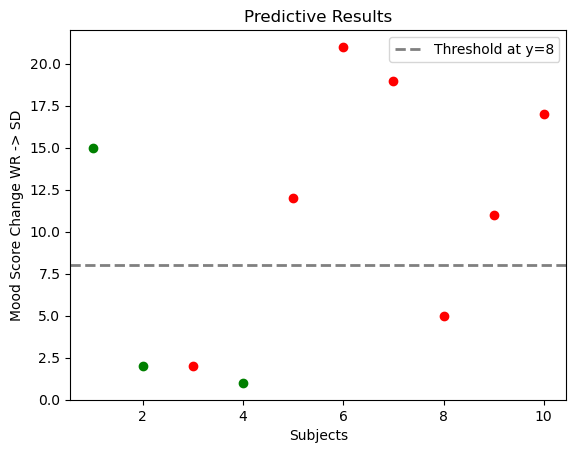

In [16]:
reg_vals = np.load('data/y_TEST_RAW_REG.npy')
thresh = 8

for i in range(len(reg_vals)):
    if preds_list[i] == 0:
        plt.plot((i+1), reg_vals[i], 'o', color='red')
    else:
        plt.plot((i+1), reg_vals[i], 'o', color='green')

plt.axhline(y=thresh, color='grey', linestyle='--', linewidth=2, label=f'Threshold at y={thresh}')

# Add labels and title
plt.xlabel("Subjects")
plt.ylabel("Mood Score Change WR -> SD")
plt.title("Predictive Results")

plt.legend()
plt.show()